# COCO API解說與簡單範例

什麼是COCO？

COCO數據集是微軟團隊發起的一個可以用來作圖像識別+分割+標題的圖像數據集，官方網址：http://cocodataset.org 。

官方除了數據以外, 也提供了一組API(一般都稱之為COCO API)來協助加載，解析和可視化COCO中的標註(annotations)。 API支持對象實例(object instance)，對象關鍵點(object keypoints)和圖像標題(image caption)標註(annotation)資訊的提取。

Ps. 由於官方版本的Python COCO tools有一個小bug會導致Python 3在操作時有錯誤產生, 因此在問題尚未被解決之前, 建議使用[[https://github.com/waleedka/coco](https://github.com/waleedka/coco)]的版本

在安裝編譯Python COCO tools的時候, 如果是Windows的平台則需要解決一些Windows上的坑, 詳請見[[Windows 10編譯Pycocotools踩坑記](http://www.jianshu.com/p/de455d653301)]

![cocodataset.org](http://cocodataset.org/images/coco-logo.png)

## 載入相關的函數模組

In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import os
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

## 設定COCO圖像資料與標註資料的路徑

在本範例中,我們下載了:
* [2014 Train/Val annotations [241MB]](http://images.cocodataset.org/annotations/annotations_trainval2014.zip)
* [2014 Train images [83K/13GB]](http://images.cocodataset.org/zips/train2014.zip)

並在本Jupyter Notebook的運行的目錄建立一個"coco"的子目錄, 然後把上述兩個檔案解壓縮到"coco"的目錄中。最後結果看起來如下:

```
xx-yyyyyy.ipynb
coco/
├── annotations/
│   ├── captions_train2014.json
│   ├── captions_val2014.json
│   ├── instances_train2014.json
│   ├── instances_val2014.json
│   ├── person_keypoints_train2014.json
│   └── person_keypoints_val2014.json
└── train2014/
    ├── COCO_train2014_000000000009.jpg
    ├── COCO_train2014_000000000025.jpg
    ├── ..
    └── COCO_train2014_000000581921.jpg
```


In [2]:
# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 置放coco圖像資料與標註資料的目錄
COCO_DATA_PATH = os.path.join(ROOT_DIR, "coco")

In [3]:
dataDir = COCO_DATA_PATH
dataType = 'train2014' # 根據下載的coco資料集的年度來設定
annFilename = 'instances_%s.json'%(dataType) # 標註的檔名隨著coco資料集的年度而有不同
annFile = os.path.join(dataDir,"annotations",annFilename) # 要解析的coco標註檔案

## COCO圖像資料與標註
在COCO的有三大類的標註資訊:
* 對象實例 `object instance`
* 對象關鍵點 `object keypoints`
* 圖像標題 `image caption`

### 對象實例(object instance) 標註

每個實例標註(object instance)包含一系列的key:value的欄位，包括對象的類別ID和圖像分割遮罩(segment mask)。分割(segment)格式取決於實例是否代表單個對象（iscrowd = 0，在這種情況下使用多邊形）或對象集合（iscrowd = 1，在這種情況下使用RLE）。請注意，單個對象（iscrowd = 0）可能需要多個多邊形，例如，如果被遮擋。人群註釋（iscrowd = 1）用於標記大量對象（例如一群人）。此外，還為每個對象提供了一個封閉的邊界框（框坐標是從左上角的圖像角度測量的，並且是0索引的）。最後，註解結構的類別字段存儲了類別標識到類別和超類別名稱的映射。

```
annotation{
    "id" : int, 
    "image_id" : int, 
    "category_id" : int, 
    "segmentation" : RLE or [polygon], 
    "area" : float, 
    "bbox" : [x,y,width,height], 
    "iscrowd" : 0 or 1,
}

categories[{
    "id" : int, 
    "name" : str, 
    "supercategory" : str,
}]
```

註解: 遊程編碼（RLE，run-length encoding），又稱行程長度編碼或變動長度編碼法，是一種與資料性質無關的無損數據壓縮技術。詳情見[維基百科](https://zh.wikipedia.org/wiki/%E6%B8%B8%E7%A8%8B%E7%BC%96%E7%A0%81)

In [4]:
# 初始化 COCO api物件的實例並載入對象實例(object instance)標註
coco=COCO(annFile)

loading annotations into memory...
Done (t=34.81s)
creating index...
index created!


## COCO工具API

為了方便取得在COCO資料集裡圖像與各種不同標註(annotations)的資訊, COCO提供了以下API方便用來提取相關資訊:

* `download` 從mscoco.org服務器下載COCO圖像
* `getAnnIds` 獲取滿足給定過濾器條件的annotation ids
* `getCatIds` 獲取滿足給定過濾條件的category ids
* `getImgIds` 獲取滿足給定過濾條件的imgage ids
* `loadAnns` 用指定的id加載annotations
* `loadCats` 使用指定的id加載categories
* `loadImgs` 用指定的id加載imgs
* `loadRes` 加載算法結果並創建用於訪問它們的API
* `showAnns` 顯示指定的標註資訊


### 顯示COCO圖像類別和超類別

```
categories[{
    "id" : int, 
    "name" : str, 
    "supercategory" : str,
}]
```

In [5]:
# 載入COCO圖像類別編碼列表
cats = coco.loadCats(coco.getCatIds()) 
nms=[cat['name'] for cat in cats]
print('COCO categories count: ', len(cats)) # 查看有多少種圖像類別
print('COCO categories: \n\n', ' '.join(nms)) # 把圖像類別打印出來

print("\n")

# 載入COCO圖像超類別編碼列表
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories count: ', len(nms)) # 查看有多少種圖像超類別
print('COCO supercategories: \n',' '.join(nms)) # 把圖像超類別打印出來

COCO categories count:  80
COCO categories: 

 person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush


COCO supercategories count:  12
COCO supercategories: 
 appliance person food indoor furniture electronic animal accessory outdoor vehicle kitchen sports


### 取得某特定類別的COCO圖像

In [6]:
# 獲取包含某特定類別的所有圖像，並隨機選擇一個
catIds = coco.getCatIds(catNms=['person','dog','skateboard']); 
imgIds = coco.getImgIds(catIds=catIds );
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

# 秀一下'img'物件資訊
img

{'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000463044.jpg',
 'date_captured': '2013-11-18 10:53:56',
 'file_name': 'COCO_train2014_000000463044.jpg',
 'flickr_url': 'http://farm1.staticflickr.com/126/418871306_6f310e657a_z.jpg',
 'height': 375,
 'id': 463044,
 'license': 1,
 'width': 500}

### 從本地的磁碟目錄中載入COCO圖像

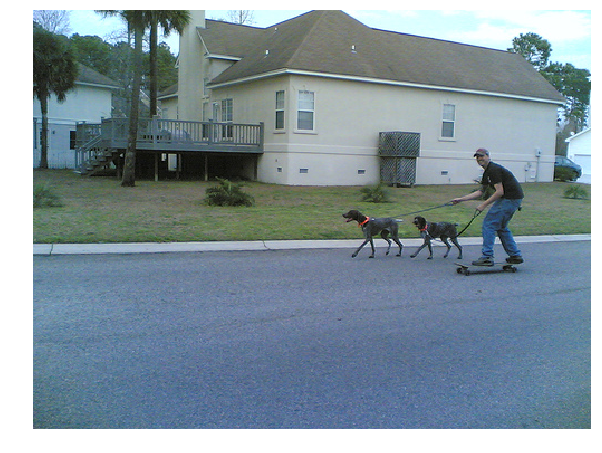

In [7]:
# 取得COCO圖像在本地目錄的路徑
img_file = os.path.join(dataDir,dataType,img['file_name'])

I = io.imread(img_file) # 載入圖像
plt.figure(); plt.axis('off')
plt.imshow(I)
plt.show()

### 從COCO的遠端伺服器載入COCO圖像

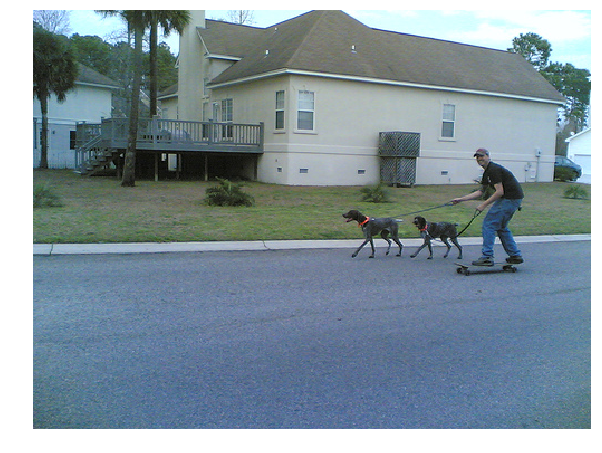

In [8]:
# 取得COCO圖像在COCO伺服器的URL
I = io.imread(img['coco_url'])
plt.figure(); plt.axis('off')
plt.imshow(I)
plt.show()

## COCO工具MASK API


COCO為每個圖像裡的對象實例(object instance)提供分割遮罩(segmentation mask)。這產生了兩個挑戰：緊湊地存儲遮罩並有效地執行遮罩計算。

我們使用自定義運行長度編碼（RLE）方案來解決這兩個挑戰。 RLE表示的大小與遮罩的邊界像素的數量成比例，並且可以直接在RLE上有效地計算諸如面積，聯合或相交的操作。

MASK API提供了一個操作RLE格式存儲的遮罩的界面。 API的定義如下:
* `encode` 使用RLE編碼二進制遮罩
* `decode` 解碼RLE編碼的二進制遮罩
* `merge` 計算遮罩的聯合(union)或交集(intersection)區域大小
* `iou` 計算遮罩iou(intersection over union)的數值
* `area` 計算遮罩的區域大小
* `toBbox` 獲取圍繞遮罩的邊界框
* `frBbox` 將邊界框轉換為編碼的遮罩
* `frPoly` 將多邊形轉換為編碼遮罩

### 載入COCO圖像的標註並疊上遮罩

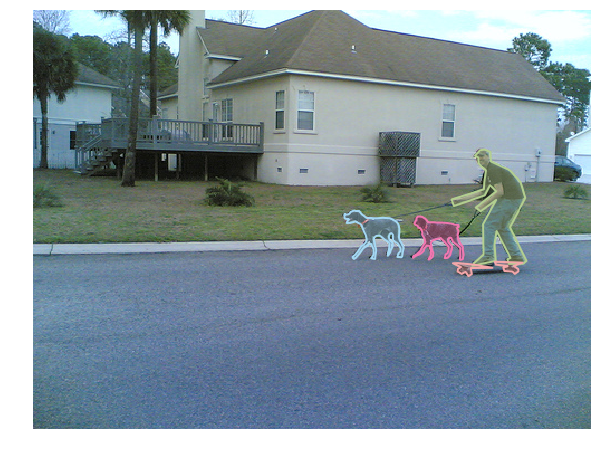

In [9]:
# 載入COCO圖像的標註並疊上遮罩
plt.imshow(I); plt.axis('off') # 秀出圖像
# 取得圖像的標註
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
# 載入標註資訊
anns = coco.loadAnns(annIds)
# 讓COCO把標註遮罩秀在圖像上
coco.showAnns(anns)

### COCO對象關鍵點 (object keypoints)

關鍵點(keypoints)註釋包含對象註釋的所有數據（包括id，bbox等）和兩個附加字段。首先，“關鍵點”是長度為3k的數組，其中k是為該類別定義的關鍵點的總數。

每個關鍵點有一個0索引的位置x，y和一個可見性標誌v，定義為v = 0：沒有標記（在這種情況下x = y = 0），v = 1：標記但不可見，v = 2：標記並可見。如果關鍵點位於對象段內部，則認為它是可見的。 

“num_keypoints”指示給定對象（許多對象，例如擁擠和小對象將具有num_keypoints = 0）的標記關鍵點的數量（v> 0）。最後，對於每個類別，類別struct還有兩個附加字段：“關鍵點”（keypoint），其是關鍵點名稱的長度k數組，以及“骨架”，其通過關鍵點邊緣對的列表定義連接性並用於可視化。

目前關鍵點僅標記為人物類別（對於大多數中/大型非人群人物實例）。

In [10]:
dataDir = COCO_DATA_PATH
dataType = 'train2014' # 根據下載的coco資料集的年度來設定
annFilename = 'person_keypoints_%s.json'%(dataType) # 標註的檔名隨著coco資料集的年度而有不同
annFile = os.path.join(dataDir,"annotations",annFilename) # 要解析的coco標註檔案

In [11]:
# 初始化 COCO api物件的實例並載入對象關鍵點(object keypoints)標註
coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=14.07s)
creating index...
index created!


### 載入COCO圖像的標註並疊上關鍵點(keypoints)

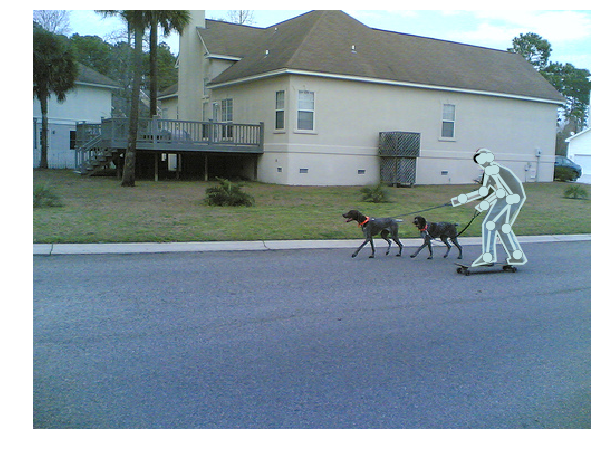

In [12]:
plt.imshow(I); plt.axis('off')
ax = plt.gca()
# 載入COCO圖像關鍵點(keypoints)標註
annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

### 載入COCO圖像標題標註(caption)

In [13]:
dataDir = COCO_DATA_PATH
dataType = 'train2014' # 根據下載的coco資料集的年度來設定
annFilename = 'captions_%s.json'%(dataType) # 標註的檔名隨著coco資料集的年度而有不同
annFile = os.path.join(dataDir,"annotations",annFilename) # 要解析的coco標註檔案

# 初始化 COCO api物件的實例並載入圖像標題(caption)標註
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=1.77s)
creating index...
index created!


### 秀出COCO圖像標題標註(caption)

A man riding a skate board while walking two dogs.
A person on a skateboard being pulled by two dogs on a city street. 
A man is being pulled on his skateboard by two dogs.
Two dogs running with man on skateboard in street.

Who needs a carriage and horses when you have two dogs to pull you along on your skateboard?


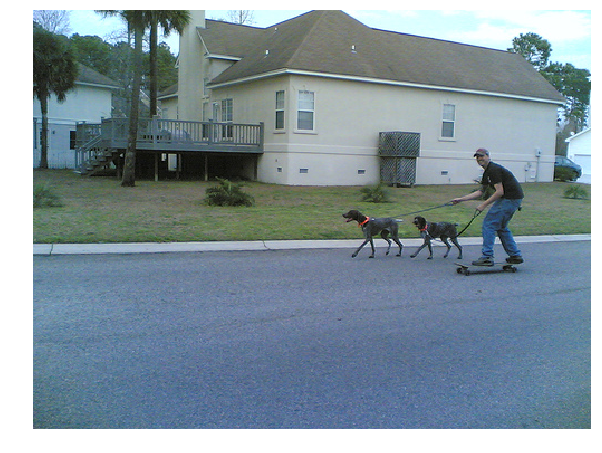

In [14]:
annIds = coco_caps.getAnnIds(imgIds=img['id']);

# 載入COCO圖像標題(caption)標註
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off')
plt.show()